## 1. Importing Data

In [31]:
import pandas as pd

import numpy as np

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt


## 2. Display Settings

- When you execute a data frame it will show you all the columns
- by default sklearn transformers output is numpy array.
We are forcing sklearn to show us DataFrame instead of np array.

In [32]:
pd.set_option("display.max_columns",None)

In [33]:
sklearn.set_config(transform_output="default")

## 3.Getting the Data

In [34]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

In [35]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


### 3.1 Split the Data 

In [36]:
def split_data(data):
    X = data.drop(columns ="price")
    y = data.price.copy()
    return (X,y)

In [37]:
X_train, y_train = split_data(train_df)
print(X_train.shape, y_train.shape)

(6695, 9) (6695,)


In [38]:
X_val, y_val = split_data(val_df)
print(X_val.shape, y_val.shape)

(1674, 9) (1674,)


In [39]:
X_test, y_test = split_data(test_df)
print(X_test.shape, y_test.shape)

(2093, 9) (2093,)


### 3.2 Meta-info

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 470.9+ KB


## 4. Data Preprocessing

In [41]:
dt_cols = ["date_of_journey","dep_time","arrival_time"]

num_cols = ["duration","total_stops"]

#cat_cols = ['airline', 'source', 'destination', 'additional_info']

cat_cols = [col for col in X_train.columns if(col not in dt_cols) and (col not in num_cols)]

In [42]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [43]:
num_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy= "most_frequent")), #mode value
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")) # Using this Output is `NumPy array`
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "most_frequent")), #mode value
    ('extractor', DatetimeFeatures(features_to_extract =['month','week','day_of_week','day_of_month'], format = 'mixed')),
    ('scaler', StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "most_frequent")), #mode value
    ('extractor', DatetimeFeatures(features_to_extract =['hour','minute'], format = 'mixed')),
    ('scaler', StandardScaler())
])

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
        ('doj',doj_transformer,["date_of_journey"]),
        ('time',time_transformer, ["dep_time","arrival_time"])
    ]
)

In [45]:
preprocessor.fit_transform(X_train)

array([[-3.67600796e-02,  3.00930116e-01,  0.00000000e+00, ...,
         1.62980523e+00,  8.24324352e-01, -9.03952976e-01],
       [ 4.27677252e-02,  3.00930116e-01,  0.00000000e+00, ...,
         3.00523012e-01, -1.36297644e+00,  1.03633329e-03],
       [-9.11565931e-01, -1.21504214e+00,  0.00000000e+00, ...,
         8.32235901e-01,  9.52240883e-02,  6.04362540e-01],
       ...,
       [-6.63041542e-01,  3.00930116e-01,  0.00000000e+00, ...,
        -1.29461565e+00,  8.24324352e-01, -1.50727918e+00],
       [-6.03395688e-01,  3.00930116e-01,  1.00000000e+00, ...,
         1.62980523e+00, -5.05959645e-02,  1.03633329e-03],
       [ 1.25556675e+00,  3.00930116e-01,  0.00000000e+00, ...,
         1.36394879e+00, -7.79696229e-01,  1.81101495e+00]],
      shape=(6695, 37))

## 5. Model Selection

In [46]:
algorithms={
    "Linear Regeression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

In [47]:
data = pd.concat([train_df,val_df], axis = 0) # row wise concatination
X_data,y_data = split_data(data)
print(X_data.shape,y_data.shape)

(8369, 9) (8369,)


In [48]:
def plot_curves(sizes, mean_scores, std_scores,label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker = "o",
        label = label
    )

    ax.fill_between(
        x = sizes,
        y1 = mean_scores - std_scores,
        y2 = mean_scores + std_scores,
        alpha = 0.5 # to make colors more dim
    )

In [49]:
def plot_learning_curves(name, algorithm, figsize = (12,4)):
    model = Pipeline(
        steps=[
            ("pre", preprocessor),
            ("alg", algorithm)
        ]
    )
    train_sizes, train_scores, test_scores = learning_curve(
        estimator = model,
        X = X_data,
        y = y_data,
        cv = 3,
        scoring="r2",
        n_jobs=-1
    )

    mean_train_scores = np.mean(train_scores, axis = 1)
    std_train_scores = np.std(train_scores, axis = 1)
    train_score = f"{mean_train_scores[-1]:.2f} ± {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis= 1)
    std_test_scores = np.std(test_scores, axis = 1)
    test_score = f"{mean_test_scores[-1]:.2f} ± {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize = figsize)

    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train: {train_score}",
        ax
    )

    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test: {test_score}",
        ax
    )

    ax.set(xlabel = "Training Set Size", ylabel = "R-square", title = name)
    ax.legend(loc="lower right")

    plt.show()

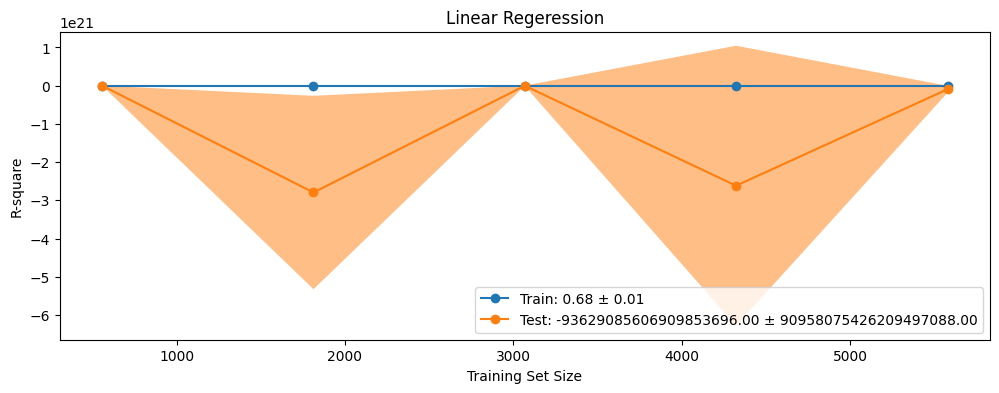

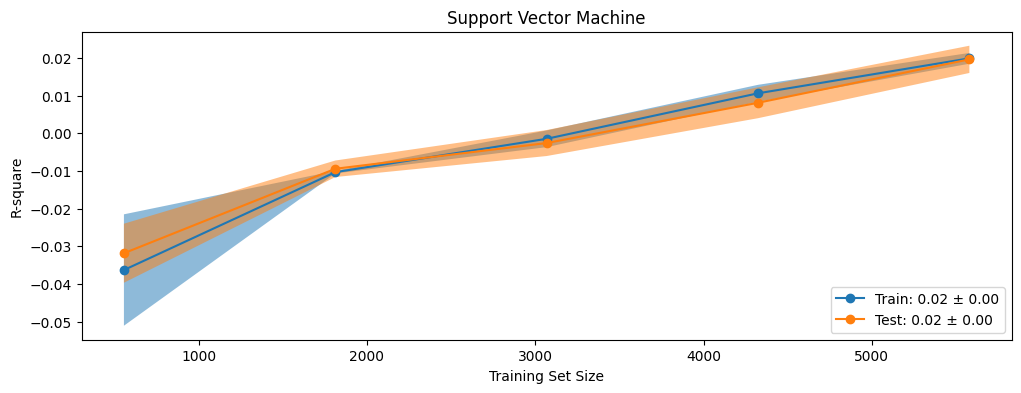

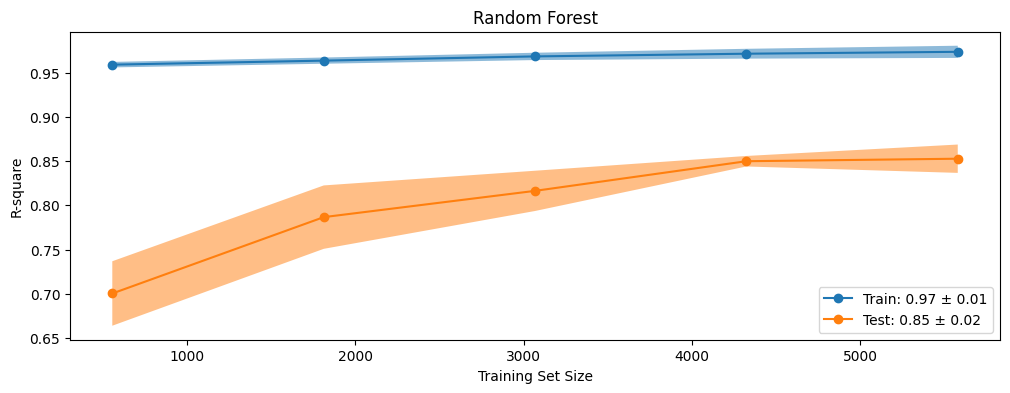

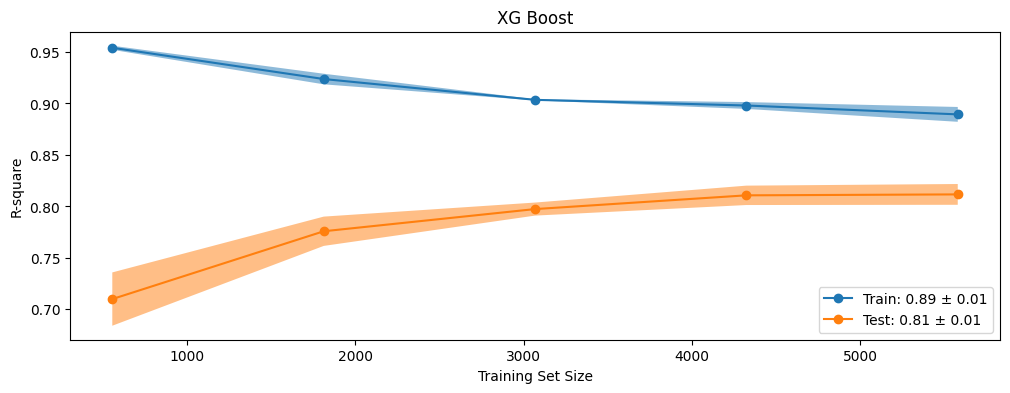

In [50]:
for name, alg in algorithms.items():
    plot_learning_curves(name,alg)

## 6. Model Pipeline

In [51]:
model = Pipeline(
    steps = [
        ("pre", preprocessor),
        ("rf", RandomForestRegressor(n_estimators = 10))
    ]
)

In [52]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7.Model Evaluation

In [53]:
def evaluate_model(X,y):
    y_pred  = model.predict(X)
    return r2_score(y, y_pred)

In [54]:
print(evaluate_model(X_data,y_data))

0.9750226165287158


In [55]:
print(evaluate_model(X_test,y_test))

0.8562900806581885


## 8.Model Persistence

In [56]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [57]:
saved_model = joblib.load("model.joblib")
saved_model 


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [58]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)


0.8562900806581885